In [1]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks

rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools

# Get ZTF fit

In [2]:
# Local Configuration
data_fink = "../"
bft_file = os.path.join(data_fink, "data", "ssoBFT-latest.parquet")

In [3]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [4]:
# ZTF filters 1: g, 2: r
filters = {"1": "g", "2": "r"}

S_color = {"g": -0.3928, "r": 0.2913}
sun_color = {"g": -0.3044, "r": 0.1903}

color_C = -(sun_color["g"] - sun_color["r"])
color_S = -(S_color["g"] - S_color["r"])

fink_colors = ["#15284F", "#F5622E"]

V_minus_g = -0.2833
V_minus_r = 0.1777

In [17]:
data = pd.read_parquet(os.path.join(data_fink, "data", "ztf", "sso_ZTF.parquet"))

In [18]:
data["SHG1G2_dSpin"] = np.sqrt(
    (data["SHG1G2_dalpha0"] * np.cos(np.radians(data["SHG1G2_delta0"]))) ** 2
    + data["SHG1G2_ddelta0"] ** 2
)


# # Remove solutions above 90 deg of latitude
cond = data.SHG1G2_delta0 > 90
data.loc[cond, "SHG1G2_delta0"] = 90
print(f"above 90: {len(data[cond])} ")

cond = data.SHG1G2_delta0 < -90
data.loc[cond, "SHG1G2_delta0"] = -90
print(f"below 90: {len(data[cond])} ")

above 90: 0 
below 90: 0 


In [19]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "orbital_elements.semi_major_axis.value",
    "orbital_elements.eccentricity.value",
    "orbital_elements.inclination.value",
    "orbital_elements.node_longitude.value",
    "orbital_elements.perihelion_argument.value",
    "orbital_elements.mean_anomaly.value",
    "orbital_elements.mean_motion.value",
    "family.family_number",
    "family.family_name",
    "proper_elements.proper_semi_major_axis.value",
    "proper_elements.proper_eccentricity.value",
    "proper_elements.proper_inclination.value",
    "proper_elements.proper_sine_inclination.value",
    "tisserand_parameters.Jupiter.value",
    "albedo.value",
    "absolute_magnitude.value",
    "diameter.value",
    "taxonomy.class",
    "taxonomy.complex",
    "taxonomy.waverange",
    "taxonomy.scheme",
    "taxonomy.technique",
    "colors.g-r.color.value",
    "colors.g-r.color.error.min",
    "colors.g-r.color.error.max",
    "colors.g-r.facility",
    "colors.g-r.observer",
    "colors.g-r.epoch",
    "colors.g-r.delta_time",
    "colors.g-r.id_filter_1",
    "colors.g-r.id_filter_2",
    "colors.g-r.phot_sys",
    "colors.g-r.technique",
    "colors.g-i.color.value",
    "colors.g-i.color.error.min",
    "colors.g-i.color.error.max",
    "colors.g-i.facility",
    "colors.g-i.observer",
    "colors.g-i.epoch",
    "colors.g-i.delta_time",
    "colors.g-i.id_filter_1",
    "colors.g-i.id_filter_2",
    "colors.g-i.phot_sys",
    "colors.g-i.technique",
    "colors.i-z.color.value",
    "colors.i-z.color.error.min",
    "colors.i-z.color.error.max",
    "colors.i-z.facility",
    "colors.i-z.observer",
    "colors.i-z.epoch",
    "colors.i-z.delta_time",
    "colors.i-z.id_filter_1",
    "colors.i-z.id_filter_2",
    "colors.i-z.phot_sys",
    "colors.i-z.technique",
    "spins.1.obliquity",
    "spins.1.RA0.value",
    "spins.1.DEC0.value",
    "spins.1.RA0.error.max",
    "spins.1.DEC0.error.max",
    "spins.1.long.value",
    "spins.1.lat.value",
    "spins.1.technique",
    "spins.2.obliquity",
    "spins.2.RA0.value",
    "spins.2.DEC0.value",
    "spins.2.RA0.error.max",
    "spins.2.DEC0.error.max",
    "spins.2.long.value",
    "spins.2.lat.value",
    "spins.2.technique",
    "spins.3.obliquity",
    "spins.3.RA0.value",
    "spins.3.DEC0.value",
    "spins.3.RA0.error.max",
    "spins.3.DEC0.error.max",
    "spins.3.long.value",
    "spins.3.lat.value",
    "spins.3.technique",
    "spins.4.obliquity",
    "spins.4.RA0.value",
    "spins.4.DEC0.value",
    "spins.4.RA0.error.max",
    "spins.4.DEC0.error.max",
    "spins.4.long.value",
    "spins.4.lat.value",
    "spins.4.technique",
]
bft = pd.read_parquet(bft_file, columns=cols)

In [20]:
data = data.merge(bft[cols], left_on="name", right_on="sso_name", how="left")

In [21]:
# data

In [22]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit == 0) & (data.HG_status >= 2)
mask_HG = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (
    (data.HG1G2_G1_g > thres)
    & (data.HG1G2_G2_g > thres)
    & ((1 - data.HG1G2_G1_g - data.HG1G2_G2_g) > thres)
)
mask_HG1G2_r = (
    (data.HG1G2_G1_r > thres)
    & (data.HG1G2_G2_r > thres)
    & ((1 - data.HG1G2_G1_r - data.HG1G2_G2_r) > thres)
)
mask_HG1G2_fit = (data.HG1G2_fit == 0) & (data.HG1G2_status >= 2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_SHG1G2_g = (
    (data.SHG1G2_G1_g > thres)
    & (data.SHG1G2_G2_g > thres)
    & ((1 - data.SHG1G2_G1_g - data.SHG1G2_G2_g) > thres)
)
mask_SHG1G2_r = (
    (data.SHG1G2_G1_r > thres)
    & (data.SHG1G2_G2_r > thres)
    & ((1 - data.SHG1G2_G1_r - data.SHG1G2_G2_r) > thres)
)
mask_SHG1G2_ZTF = mask_SHG1G2_g & mask_SHG1G2_r
mask_SHG1G2_fit = (data.SHG1G2_fit == 0) & (data.SHG1G2_status >= 2)
mask_SHG1G2 = mask_SHG1G2_fit & mask_SHG1G2_ZTF


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (
    (data.SHG1G2_alpha0 > thres)
    & (np.abs(360 - data.SHG1G2_alpha0) > thres)
    & (np.abs(data.SHG1G2_alpha0 - 180) > thres)
    & (np.abs(data.SHG1G2_delta0) > thres)
)

# Phase coverage
maskPhase = data.min_phase < 2.5

# Global mask
maskFINK = mask_SHG1G2 & maskSpin  # & maskPhase


print(f" All data       : {len(data):6d}  ({100:>6.2f}%)")
print()
print(
    f"  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask SHG1G2 g  : {len(data[mask_SHG1G2_g]):6d}  ({100.*len(data[mask_SHG1G2_g])/len(data):>6.2f}%)"
)
print(
    f"  Mask SHG1G2 r  : {len(data[mask_SHG1G2_r]):6d}  ({100.*len(data[mask_SHG1G2_r])/len(data):>6.2f}%)"
)
print(
    f"  Mask SHG1G2 g+r: {len(data[mask_SHG1G2]):6d}  ({100.*len(data[mask_SHG1G2])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask FINK      : {len(data[maskFINK]):6d}  ({100.*len(data[maskFINK])/len(data):>6.2f}%)"
)
for minphase in [2, 3, 4, 5]:
    maskPhase = data.min_phase < minphase
    print(
        f"  Mask phase {minphase}   : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)"
    )

 All data       : 122675  (100.00%)

  Mask HG g      : 122371  ( 99.75%)
  Mask HG r      : 122373  ( 99.75%)
  Mask HG g+r    : 120010  ( 97.83%)

  Mask HG1G2 g   :  63922  ( 52.11%)
  Mask HG1G2 r   :  68956  ( 56.21%)
  Mask HG1G2 g+r :  47175  ( 38.46%)

  Mask SHG1G2 g  :  79912  ( 65.14%)
  Mask SHG1G2 r  :  84779  ( 69.11%)
  Mask SHG1G2 g+r:  64209  ( 52.34%)

  Mask Spin      : 118811  ( 96.85%)

  Mask FINK      :  62943  ( 51.31%)
  Mask phase 2   :  62923  ( 51.29%)
  Mask phase 3   :  86161  ( 70.24%)
  Mask phase 4   : 100699  ( 82.09%)
  Mask phase 5   : 109011  ( 88.86%)


# General description of the sample

In [23]:
data.loc[maskFINK, "sso_class"].value_counts()

sso_class
MB>Inner        20645
MB>Middle       19920
MB>Outer        17200
Phocaea           581
Trojan            544
Hungaria          452
Mars-Crosser      439
MB>Cybele         276
MB>Hilda          243
NEA>Amor           44
NEA>Apollo         44
NEA>Aten            3
Centaur             2
KBO>SDO             1
Name: count, dtype: int64

Text(0, 0.5, 'Sine of inclination ($\\sin$i)')

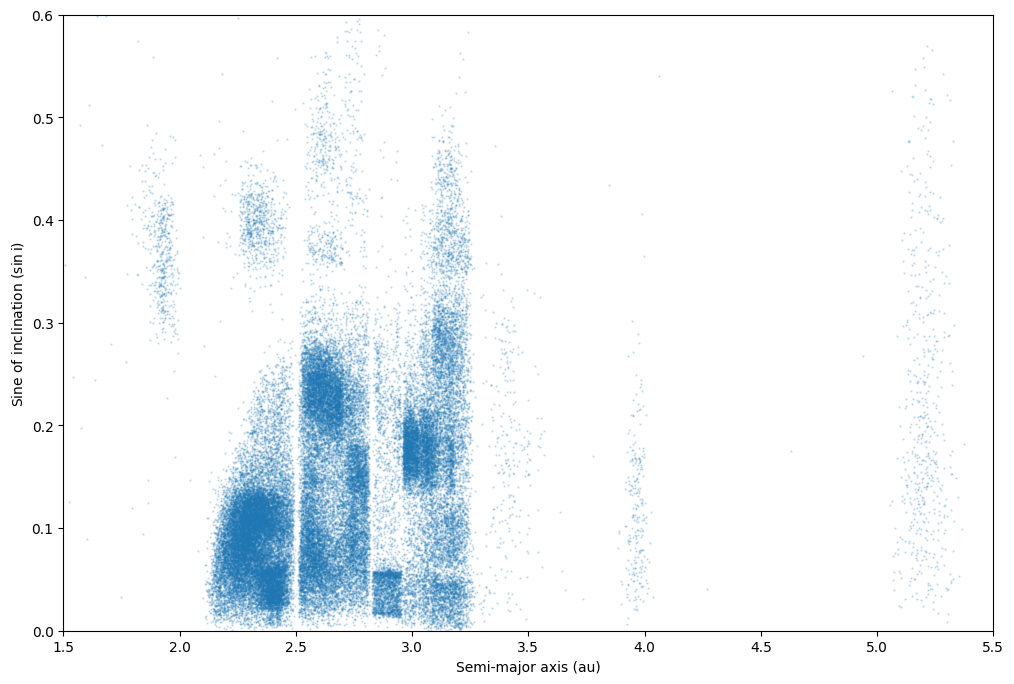

In [24]:
As = data.loc[maskFINK, "orbital_elements.semi_major_axis.value"]
Es = data.loc[maskFINK, "orbital_elements.eccentricity.value"]
node = data.loc[maskFINK, "orbital_elements.inclination.value"]

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(As, np.sin(np.radians(node)), marker=".", alpha=0.2, s=2)


ax.set_xlim(1.5, 5.5)
ax.set_ylim(0, 0.6)
ax.set_xlabel("Semi-major axis (au)")
ax.set_ylabel(r"Sine of inclination ($\sin$i)")

# fig.savefig(f'{data_fink}plots/types.png', facecolor='white', dpi=150)

# Spins!

In [25]:
data.columns[ data.columns.str.contains('alpha0') ]

Index(['SHG1G2_alpha0', 'SHG1G2_dalpha0', 'SHG1G2_alpha0_alt'], dtype='object')

In [28]:
# Create alternative spins solutions
xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

# Already done at Fink level
# data["SHG1G2_alpha0_alt"] = (data["SHG1G2_alpha0"] + 180) % 360
# data["SHG1G2_delta0_alt"] = -data["SHG1G2_delta0"]


data["SHG1G2_alpha0_rand"] = data["SHG1G2_alpha0"]
data["SHG1G2_delta0_rand"] = data["SHG1G2_delta0"]
cond = (data.index % 2) == 0
data.loc[cond, "SHG1G2_alpha0_rand"] = data.loc[cond, "SHG1G2_alpha0_alt"]
data.loc[cond, "SHG1G2_delta0_rand"] = data.loc[cond, "SHG1G2_delta0_alt"]


# Convert to EC
coords = SkyCoord(
    ra=data["SHG1G2_alpha0"].values * u.deg,
    dec=data["SHG1G2_delta0"].values * u.deg,
    distance=200 * u.parsec,
    frame="hcrs",
)
data["lon"] = coords.heliocentricmeanecliptic.lon.value
data["lat"] = coords.heliocentricmeanecliptic.lat.value

coords = SkyCoord(
    ra=data["SHG1G2_alpha0_alt"].values * u.deg,
    dec=data["SHG1G2_delta0_alt"].values * u.deg,
    distance=200 * u.parsec,
    frame="hcrs",
)
data["lon_alt"] = coords.heliocentricmeanecliptic.lon.value
data["lat_alt"] = coords.heliocentricmeanecliptic.lat.value


coords = SkyCoord(
    ra=data["SHG1G2_alpha0_rand"].values * u.deg,
    dec=data["SHG1G2_delta0_rand"].values * u.deg,
    distance=200 * u.parsec,
    frame="hcrs",
)
data["lon_rand"] = coords.heliocentricmeanecliptic.lon.value
data["lat_rand"] = coords.heliocentricmeanecliptic.lat.value

In [29]:
# Obliquity of the spin
data["lon_orbit"] = data["orbital_elements.node_longitude.value"] - 90
data["lat_orbit"] = 90.0 - data["orbital_elements.inclination.value"]
data["obliquity"] = data[["lon", "lat", "lon_orbit", "lat_orbit"]].apply(
    lambda x: np.degrees(
        angular_separation(
            np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
        )
    ),
    axis=1,
)
data["obliquity_alt"] = data[["lon_alt", "lat_alt", "lon_orbit", "lat_orbit"]].apply(
    lambda x: np.degrees(
        angular_separation(
            np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
        )
    ),
    axis=1,
)

/tmp/ipykernel_974215/3937172300.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
/tmp/ipykernel_974215/3937172300.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])


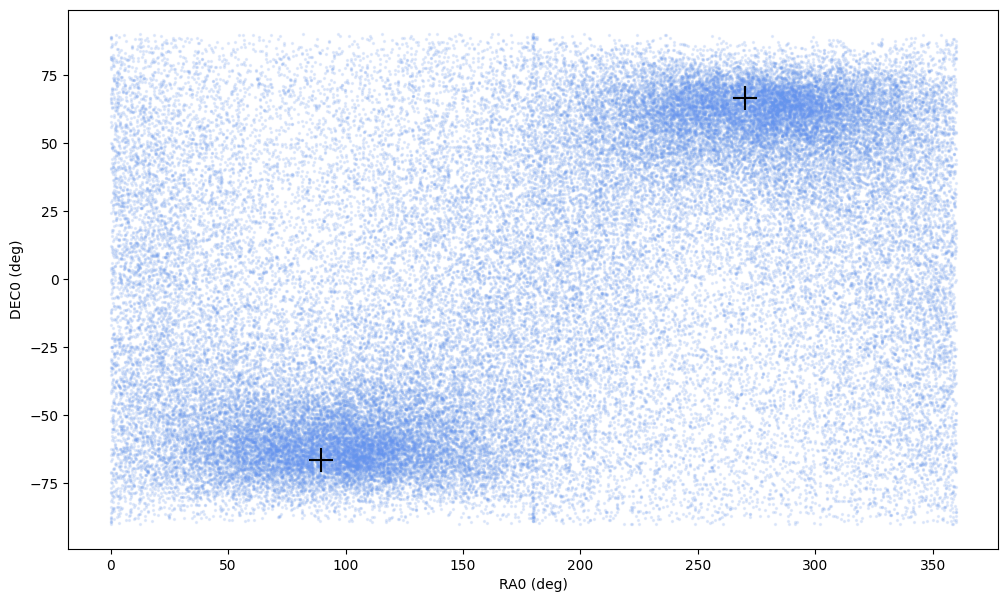

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

# Sample FINK
cond = (data.index % 2) == 0
ax.scatter(
    data.loc[cond & maskFINK, "SHG1G2_alpha0"],
    data.loc[cond & maskFINK, "SHG1G2_delta0"],
    s=2,
    alpha=0.15,
    color="cornflowerblue",
)
ax.scatter(
    data.loc[~cond & maskFINK, "SHG1G2_alpha0_alt"],
    data.loc[~cond & maskFINK, "SHG1G2_delta0_alt"],
    s=2,
    alpha=0.15,
    color="cornflowerblue",
)

# Ecliptic poles
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=-89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)


ax.set_xlabel("RA0 (deg)")
ax.set_ylabel("DEC0 (deg)")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_selected.png"), facecolor="white"
)

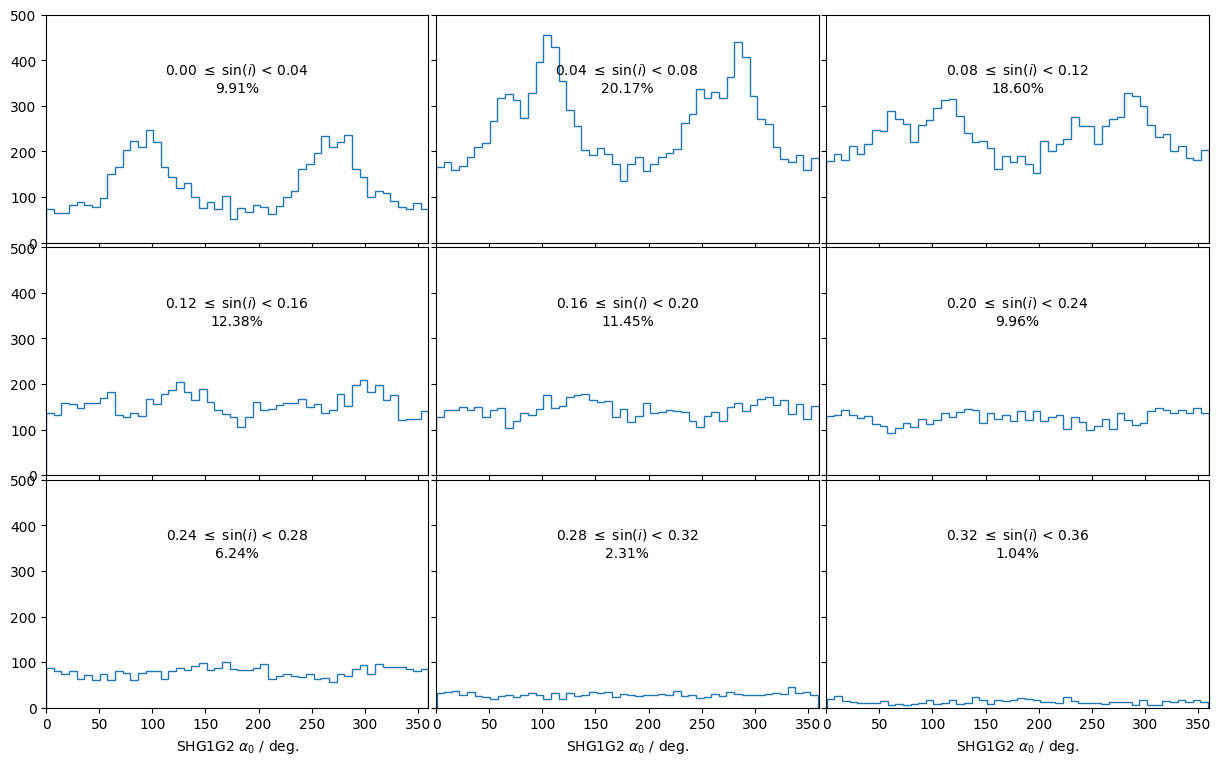

In [33]:
Is = np.sin(np.deg2rad(data["orbital_elements.inclination.value"]))

fig, ax = plt.subplots(
    3,
    3,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
m = maskFINK

step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):
        mi = (Is[m] >= count * step) * (Is[m] < (count + 1) * step)
        ax[i, j].hist(
            data["SHG1G2_alpha0_rand"][m][mi],
            bins=50,
            density=False,
            histtype="step",
            label="{:.2f}%".format(
                len(data["SHG1G2_alpha0_rand"][m][mi])
                / len(data["SHG1G2_alpha0_rand"][m])
                * 100
            ),
        )

        ax[i, j].text(
            180,
            370,
            r"{:.2f} $\leq$ $\sin(i)$ < {:.2f}".format(
                count * step, (count + 1) * step
            ),
            ha="center",
        )
        ax[i, j].text(
            180,
            330,
            "{:.2f}%".format(
                len(data["SHG1G2_alpha0_rand"][m][mi])
                / len(data["SHG1G2_alpha0_rand"][m])
                * 100
            ),
            ha="center",
        )
        count += 1

        # only on the last one
        # ax[i, j].legend(fontsize=10)

for a in ax[2, :]:
    a.set_xlabel(r"SHG1G2 $\alpha_0$ / deg.")
ax[0, 0].set_ylim(0, 500)
ax[0, 0].set_xlim(0, 360)

# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/ra0_vs_incl_distrib.png', facecolor='white', dpi=150)
plt.show()

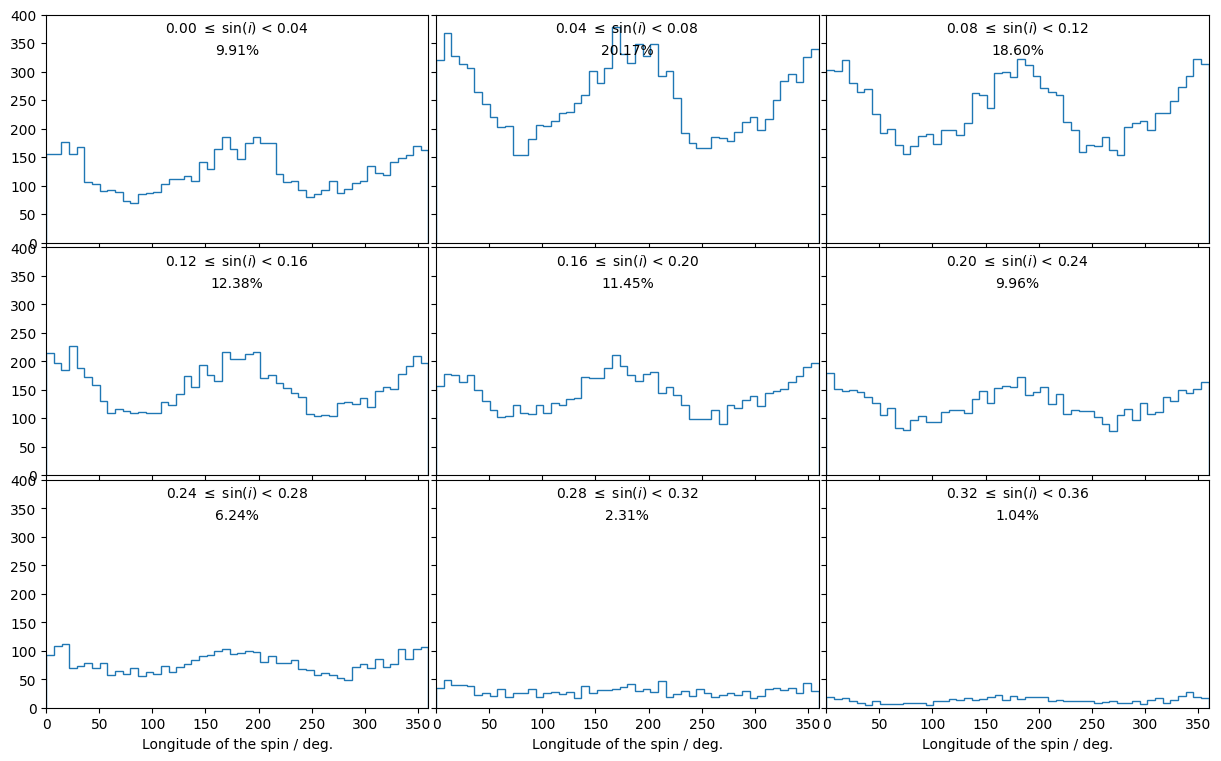

In [96]:
Is = np.sin(np.deg2rad(data["orbital_elements.inclination.value"]))

fig, ax = plt.subplots(
    3,
    3,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
m = maskFINK

step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):
        mi = (Is[m] >= count * step) * (Is[m] < (count + 1) * step)
        ax[i, j].hist(
            data["lon_rand"][m][mi],
            bins=50,
            density=False,
            histtype="step"
        )

        ax[i, j].text(
            180,
            370,
            r"{:.2f} $\leq$ $\sin(i)$ < {:.2f}".format(
                count * step, (count + 1) * step
            ),
            ha="center",
        )
        ax[i, j].text(
            180,
            330,
            "{:.2f}%".format(
                len(data["lon_rand"][m][mi])
                / len(data["lon_rand"][m])
                * 100
            ),
            ha="center",
        )
        count += 1

        # only on the last one
        # ax[i, j].legend(fontsize=10)

for a in ax[2, :]:
    a.set_xlabel(r"Longitude of the spin / deg.")
ax[0, 0].set_ylim(0, 400)
ax[0, 0].set_xlim(0, 360)

# for a in ax.ravel():
#     a.fill_betweenx( [0,400], [0,0], [60,60], color='green', alpha=0.2)
#     a.fill_betweenx( [0,400], [180,180], [240,240], color='green', alpha=0.2)
#     a.fill_betweenx( [0,400], [130,130], [160,160], color='blue', alpha=0.2)
#     a.fill_betweenx( [0,400], [310,310], [340,340], color='blue', alpha=0.2)


# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/ra0_vs_incl_distrib.png', facecolor='white', dpi=150)
plt.show()

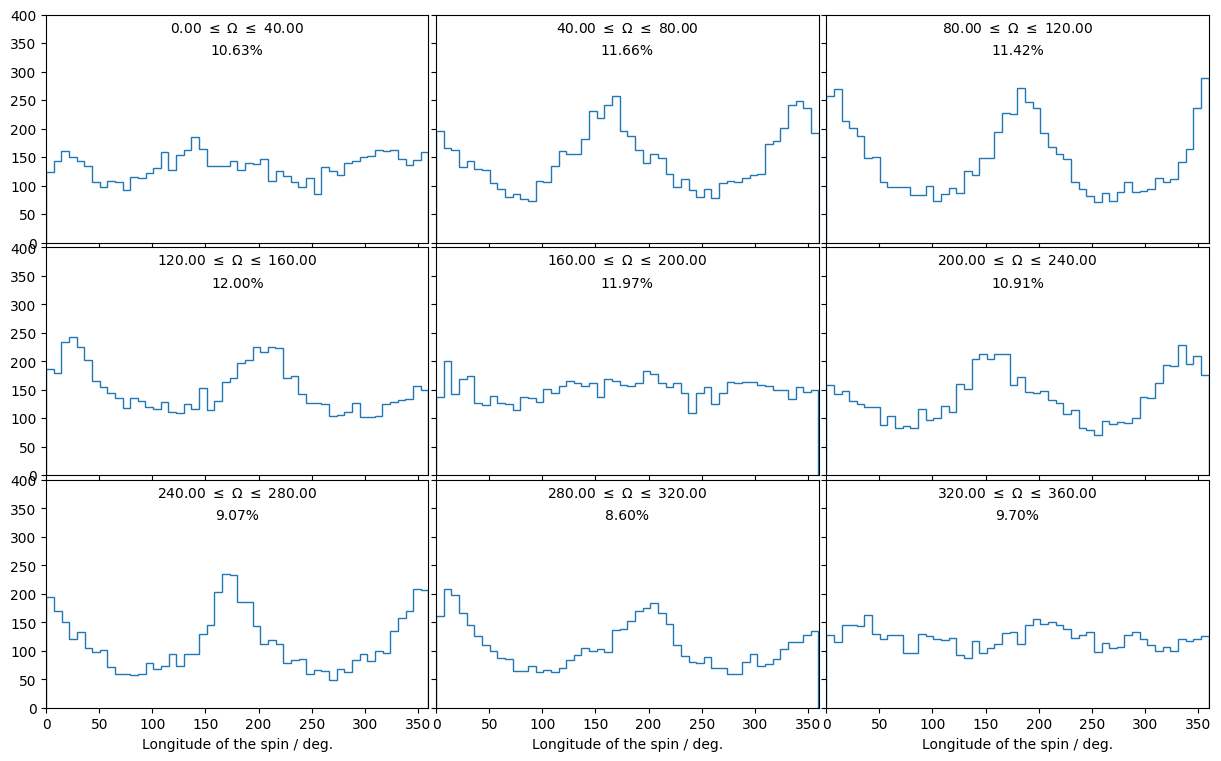

In [57]:
node = data["orbital_elements.node_longitude.value"]

fig, ax = plt.subplots(
    3,
    3,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
m = maskFINK

step = 40
count = 0
for i in range(0, 3):
    for j in range(0, 3):
        mi = (node[m] >= count * step) * (node[m] < (count + 1) * step)
        ax[i, j].hist(
            data["lon_rand"][m][mi],
            bins=50,
            density=False,
            histtype="step"
        )

        ax[i, j].text(
            180,
            370,
            r"{:.2f} $\leq$ $\Omega $ $\leq$ {:.2f}".format(
                count * step, (count + 1) * step
            ),
            ha="center",
        )
        ax[i, j].text(
            180,
            330,
            "{:.2f}%".format(
                len(data["lon_rand"][m][mi])
                / len(data["lon_rand"][m])
                * 100
            ),
            ha="center",
        )
        count += 1

        # only on the last one
        # ax[i, j].legend(fontsize=10)

for a in ax[2, :]:
    a.set_xlabel(r"Longitude of the spin / deg.")
ax[0, 0].set_ylim(0, 400)
ax[0, 0].set_xlim(0, 360)

# for a in ax.ravel():
#     a.fill_betweenx( [0,400], [0,0], [60,60], color='green', alpha=0.2)
#     a.fill_betweenx( [0,400], [180,180], [240,240], color='green', alpha=0.2)
#     a.fill_betweenx( [0,400], [130,130], [160,160], color='blue', alpha=0.2)
#     a.fill_betweenx( [0,400], [310,310], [340,340], color='blue', alpha=0.2)


# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/ra0_vs_incl_distrib.png', facecolor='white', dpi=150)
plt.show()

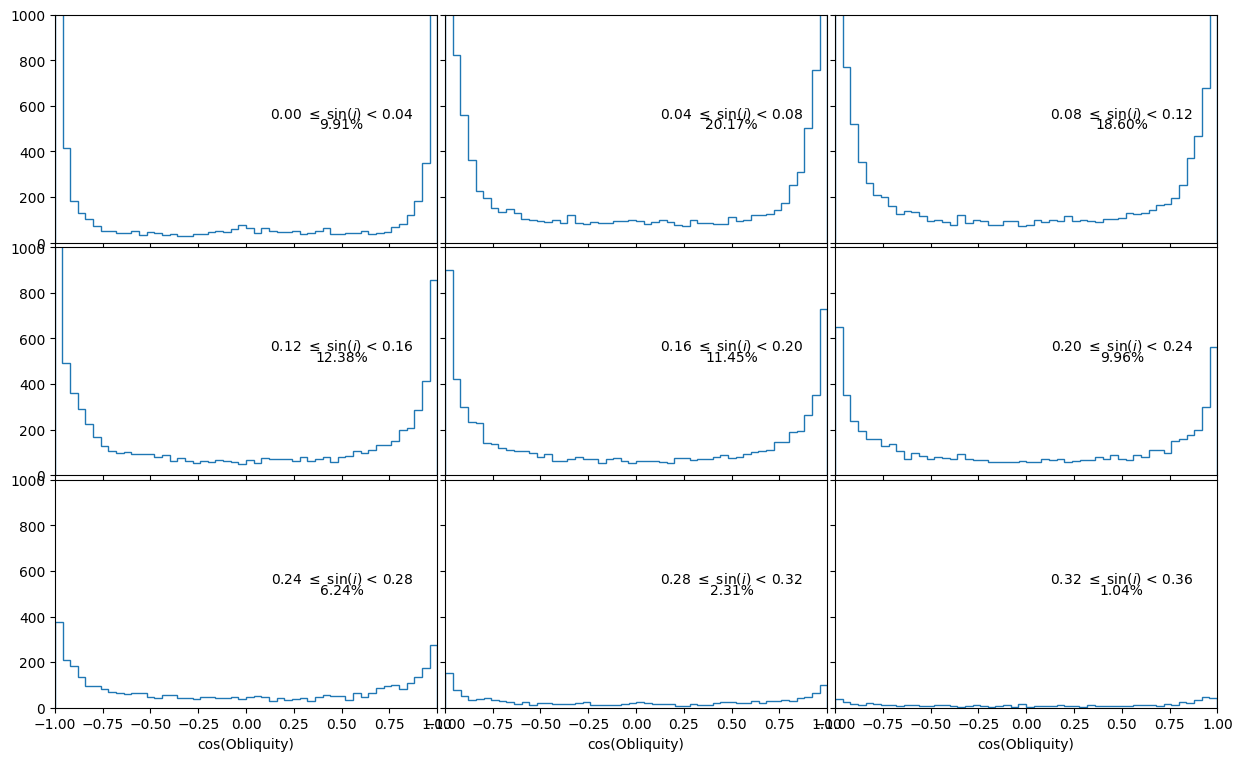

In [35]:
Is = np.sin(np.deg2rad(data["orbital_elements.inclination.value"]))

fig, ax = plt.subplots(
    3,
    3,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
m = maskFINK


step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):
        mi = (Is[m] >= count * step) * (Is[m] < (count + 1) * step)
        ax[i, j].hist(
            np.cos(np.radians(data["obliquity"][m][mi])),
            bins=50,
            density=False,
            histtype="step",
            label="{:.2f}%".format(
                len(data["obliquity"][m][mi]) / len(data["obliquity"][m]) * 100
            ),
        )
        ax[i, j].text(
            0.5,
            550,
            r"{:.2f} $\leq$ $\sin(i)$ < {:.2f}".format(
                count * step, (count + 1) * step
            ),
            ha="center",
        )
        ax[i, j].text(
            0.5,
            500,
            "{:.2f}%".format(
                len(data["obliquity"][m][mi]) / len(data["obliquity"][m]) * 100
            ),
            ha="center",
        )
        # ax[i, j].set_title(
        #     r"{:.2f} $\leq$ $\sin(i)$ < {:.2f}".format(count * step, (count + 1) * step)
        # )
        # ax[i, j].set_xlim(0, 180)
        count += 1

        # only on the last one
        # ax[i, j].legend(fontsize=10)
for a in ax[2, :]:
    a.set_xlabel(r"cos(Obliquity)")
ax[0, 0].set_ylim(0, 1000)
ax[0, 0].set_xlim(-1,1)
# plt.xlabel(r"$obliquity$ [deg]")
# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/obliquity_vs_incl_distrib_with_flip.png', facecolor='white', dpi=150)
plt.show()

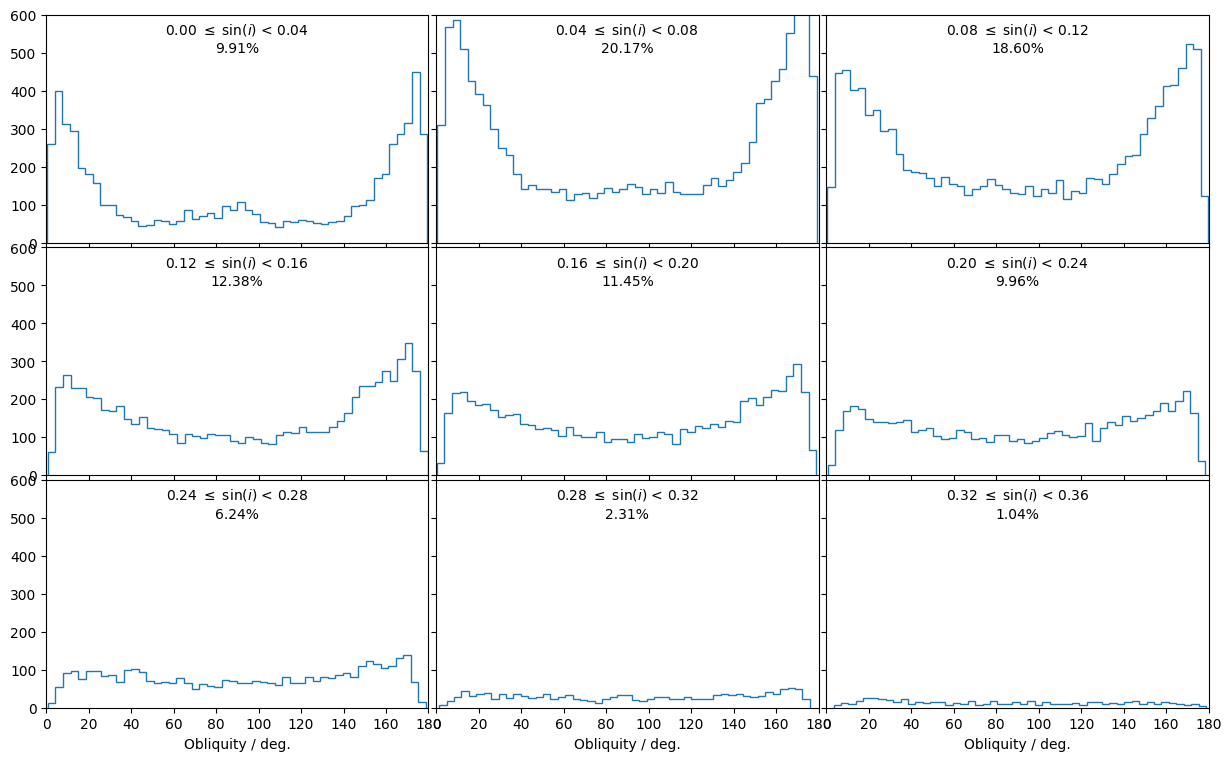

In [36]:
Is = np.sin(np.deg2rad(data["orbital_elements.inclination.value"]))

fig, ax = plt.subplots(
    3,
    3,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
m = maskFINK


step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):
        mi = (Is[m] >= count * step) * (Is[m] < (count + 1) * step)
        ax[i, j].hist(
            data["obliquity"][m][mi],
            bins=50,
            density=False,
            histtype="step",
            label="{:.2f}%".format(
                len(data["obliquity"][m][mi]) / len(data["obliquity"][m]) * 100
            ),
        )
        ax[i, j].text(
            90,
            550,
            r"{:.2f} $\leq$ $\sin(i)$ < {:.2f}".format(
                count * step, (count + 1) * step
            ),
            ha="center",
        )
        ax[i, j].text(
            90,
            500,
            "{:.2f}%".format(
                len(data["obliquity"][m][mi]) / len(data["obliquity"][m]) * 100
            ),
            ha="center",
        )
        # ax[i, j].set_title(
        #     r"{:.2f} $\leq$ $\sin(i)$ < {:.2f}".format(count * step, (count + 1) * step)
        # )
        # ax[i, j].set_xlim(0, 180)
        count += 1

        # only on the last one
        # ax[i, j].legend(fontsize=10)
for a in ax[2, :]:
    a.set_xlabel(r"Obliquity / deg.")
ax[0, 0].set_ylim(0, 600)
ax[0, 0].set_xlim(0, 180)
# plt.xlabel(r"$obliquity$ [deg]")
# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/obliquity_vs_incl_distrib_with_flip.png', facecolor='white', dpi=150)
plt.show()

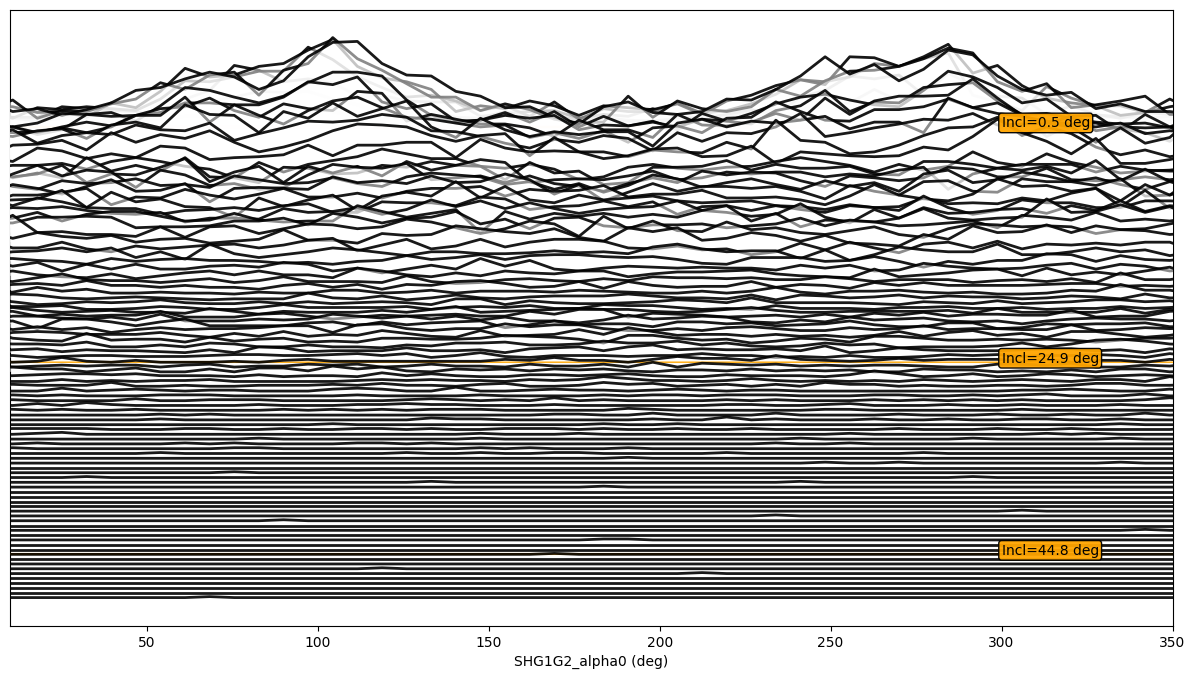

In [37]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

cond = maskFINK

d_1 = data.loc[cond, "SHG1G2_alpha0_rand"]
Is = np.sin(np.deg2rad(data["orbital_elements.inclination.value"]))
d_2 = Is[cond]

# d_2 contains NaN...?
cond2 = d_2 == d_2
d_1 = d_1[cond2]
d_2 = d_2[cond2]

H, x, y = np.histogram2d(d_1, d_2, bins=(50, 100))

nx = len(H)
ny = len(H[0])
fig = plt.figure(figsize=(15, 8), facecolor="w")
ax = fig.add_subplot(111)
maxs = []
for iy in range(ny):
    # Offset each line by this amount: we want the first lines plotted
    # at the top of the chart and to work our way down
    offset = (ny - iy) * 5
    # Plot the line and fill under it: increase the z-order each time
    # so that lower lines and their fills are plotted over higher ones
    #     yhat = savgol_filter(H.T[iy], 7, 3)
    yhat = H.T[iy]
    xcenters = (x[:-1] + x[1:]) / 2
    ax.plot(xcenters, yhat + offset, "k", lw=2, zorder=(iy + 1) * 2, alpha=0.9)
    ax.fill_between(
        xcenters,
        yhat + offset,
        offset,
        facecolor="w",
        lw=0,
        zorder=(iy + 1) * 2 - 1,
        alpha=0.5,
    )
    if np.max(yhat) > 1.1 * np.mean(yhat):
        max_ = np.argmax(yhat)
        maxs.append([xcenters[max_], yhat[max_]])
ax.get_yaxis().set_visible(False)

for incl in [10, int(ny / 2), ny - 1]:
    ax.text(
        300,
        offset * incl,
        "Incl={:.1f} deg".format(np.rad2deg(y[::-1][:-1][incl])),
        color="black",
        bbox=dict(
            facecolor="orange", edgecolor="black", boxstyle="round,pad=0.2", alpha=0.95
        ),
        zorder=1e6,
    )
    plt.axhline(offset * incl, color="orange", zorder=5)
plt.xlim(10, 350)
plt.xlabel("SHG1G2_alpha0 (deg)")
# fig.savefig(f'{data_fink}plots/ra0_vs_incl_waterfall.png', facecolor='white', dpi=150)
plt.show()

# Oblateness

Text(0, 0.5, 'Oblateness R')

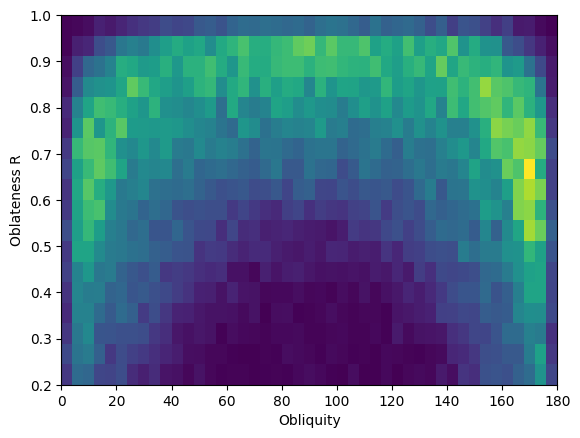

In [38]:
fig, ax = plt.subplots()

# ax.hist2d( data['obliquity'], data['SHG1G2_R'], range=[ [0,180],[0.2,1]], bins=[45,18])
ax.hist2d( data.loc[maskFINK,'obliquity'], data.loc[maskFINK,'SHG1G2_R'], range=[ [0,180],[0.2,1]], bins=[45,18])

# ax.set_xscale('log')
ax.set_xlabel('Obliquity')
ax.set_ylabel('Oblateness R')

In [39]:
# fig, ax = plt.subplots()


# # ax.hist2d( data['diameter.value'], data['SHG1G2_R'], range=[ [1,100],[0.2,1]], bins=[100,18])
# # ax.hist2d( data['orbital_elements.semi_major_axis.value'], data['SHG1G2_R'], range=[ [1,3],[0.2,1]], bins=[10,18])
# # ax.hist2d( data['orbital_elements.inclination.value'], data['SHG1G2_R'], range=[ [0,40],[0.2,1]], bins=[10,18])

# # ax.set_xscale('log')
# ax.set_xlabel('Obliquity')
# ax.set_ylabel('Oblateness R')

Text(0.5, 0, 'Oblateness R')

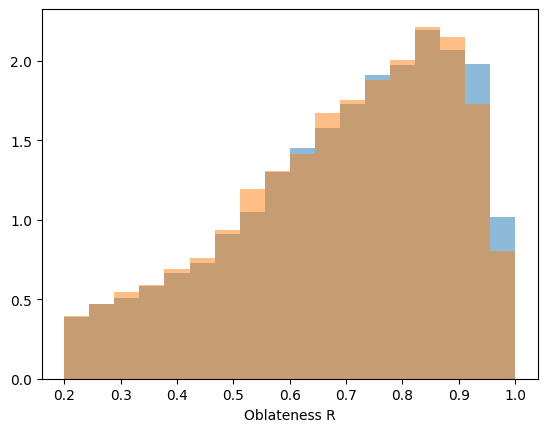

In [40]:
fig, ax = plt.subplots()

for c in ['S','C']:
    cond = maskFINK & (data['taxonomy.complex']==c)
    ax.hist( data.loc[cond, 'SHG1G2_R'], range=[0.2,1], bins=18, density=True, alpha=0.5)

# ax.set_xscale('log')
ax.set_xlabel('Oblateness R')

In [41]:
data.columns[80:180]

Index(['mean_astrometry', 'std_astrometry', 'skew_astrometry',
       'kurt_astrometry', 'n_days', 'n_days_g', 'n_days_r', 'last_jd', 'name',
       'number', 'SHG1G2_obliquity', 'SHG1G2_alpha0_alt', 'SHG1G2_delta0_alt',
       'version', 'SHG1G2_flag', 'SHG1G2_dSpin', 'sso_number', 'sso_name',
       'sso_class', 'orbital_elements.semi_major_axis.value',
       'orbital_elements.eccentricity.value',
       'orbital_elements.inclination.value',
       'orbital_elements.node_longitude.value',
       'orbital_elements.perihelion_argument.value',
       'orbital_elements.mean_anomaly.value',
       'orbital_elements.mean_motion.value', 'family.family_number',
       'family.family_name', 'proper_elements.proper_semi_major_axis.value',
       'proper_elements.proper_eccentricity.value',
       'proper_elements.proper_inclination.value',
       'proper_elements.proper_sine_inclination.value',
       'tisserand_parameters.Jupiter.value', 'albedo.value',
       'absolute_magnitude.value', 'di

# Phase parameters

In [42]:
data.loc[maskFINK, "taxonomy.complex"].value_counts()

taxonomy.complex
S     16022
C      6894
X      4036
V      2211
B      1471
L      1396
U      1038
D      1011
K       793
A       604
Q       237
Ch      201
P       186
M       135
Z        22
T        18
E        14
R         9
O         2
Name: count, dtype: int64

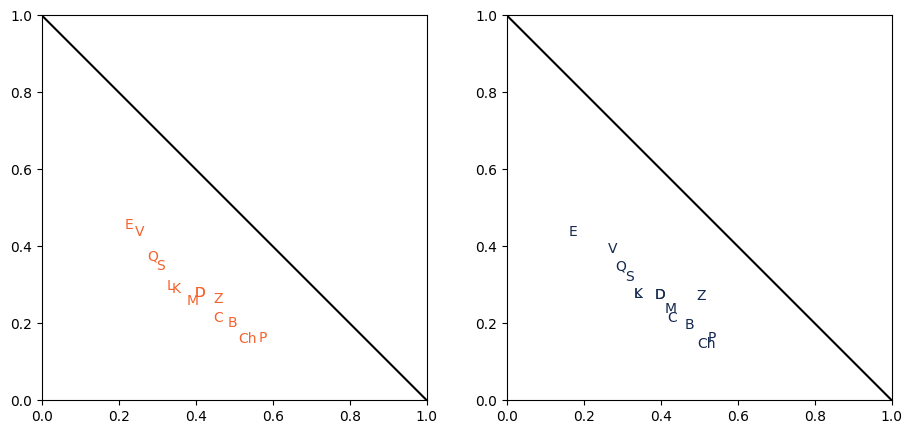

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

xx = np.linspace(0, 1, num=10)

for a in ax:
    a.plot(xx, 1 - xx, linestyle="solid", color="black")
    a.set_aspect("equal")
    a.set_xlim(0, 1)
    a.set_ylim(0, 1)

for c in ["E", "V", "Q", "S", "C", "B", "D", "K", "L", "D", "Ch", "P", "M", "Z"]:
    cond = maskFINK & (data["taxonomy.complex"] == c)

    G1_m = data.loc[cond, "SHG1G2_G1_g"].mean()
    G1_s = data.loc[cond, "SHG1G2_G1_g"].std()
    G2_m = data.loc[cond, "SHG1G2_G2_g"].mean()
    G2_s = data.loc[cond, "SHG1G2_G2_g"].std()

    # print(f'{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}')
    ax[1].text(G1_m, G2_m, c, ha="center", va="center", color=fink_colors[0])

    G1_m = data.loc[cond, "SHG1G2_G1_r"].mean()
    G1_s = data.loc[cond, "SHG1G2_G1_r"].std()
    G2_m = data.loc[cond, "SHG1G2_G2_r"].mean()
    G2_s = data.loc[cond, "SHG1G2_G2_r"].std()

    # print(f'{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}')
    ax[0].text(G1_m, G2_m, c, ha="center", va="center", color=fink_colors[1])

E    0.23 0.17    0.46 0.21
V    0.25 0.15    0.44 0.10
Q    0.29 0.16    0.37 0.10
A    0.30 0.17    0.36 0.10
S    0.31 0.17    0.35 0.10
L    0.34 0.19    0.30 0.12
K    0.35 0.19    0.29 0.11
D    0.41 0.22    0.28 0.12
M    0.39 0.20    0.26 0.10
Z    0.46 0.25    0.26 0.16
C    0.46 0.23    0.21 0.13
B    0.49 0.22    0.20 0.13
Ch   0.54 0.20    0.16 0.09
P    0.57 0.21    0.16 0.11


Text(0.35444699555537634, 0.3052874517521633, 'All')

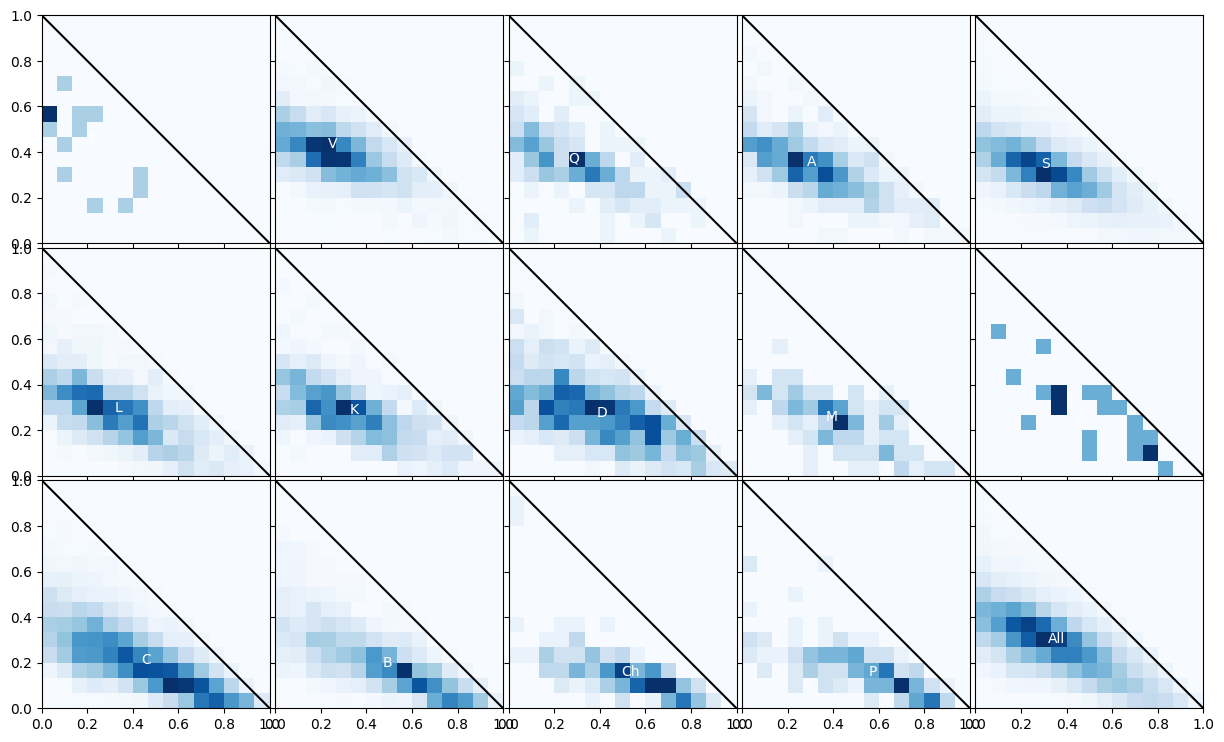

In [44]:
fig, ax = plt.subplots(
    3,
    5,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
axs = ax.ravel()

xx = np.linspace(0, 1, num=20)

for a in axs:
    a.plot(xx, 1 - xx, linestyle="solid", color="black")
    a.set_aspect("equal")
    a.set_xlim(0, 1)
    a.set_ylim(0, 1)

r = [[0, 1], [0, 1]]
b = 15
for i, c in enumerate(
    ["E", "V", "Q", "A", "S", "L", "K", "D", "M", "Z", "C", "B", "Ch", "P"]
):
    cond = maskFINK & (data["taxonomy.complex"] == c)

    G1_m = data.loc[cond, "SHG1G2_G1_r"].mean()
    G1_s = data.loc[cond, "SHG1G2_G1_r"].std()
    G2_m = data.loc[cond, "SHG1G2_G2_r"].mean()
    G2_s = data.loc[cond, "SHG1G2_G2_r"].std()

    print(f"{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}")

    axs[i].hist2d(
        data.loc[cond, "SHG1G2_G1_g"],
        data.loc[cond, "SHG1G2_G2_g"],
        range=r,
        bins=b,
        cmap="Blues",
    )
    axs[i].text(G1_m, G2_m, c, ha="center", va="center", color="white")

i = i + 1
G1_m = data.loc[maskFINK, "SHG1G2_G1_r"].mean()
G1_s = data.loc[maskFINK, "SHG1G2_G1_r"].std()
G2_m = data.loc[maskFINK, "SHG1G2_G2_r"].mean()
G2_s = data.loc[maskFINK, "SHG1G2_G2_r"].std()
axs[i].hist2d(
    data.loc[maskFINK, "SHG1G2_G1_g"],
    data.loc[maskFINK, "SHG1G2_G2_g"],
    range=r,
    bins=b,
    cmap="Blues",
)
axs[i].text(G1_m, G2_m, "All", ha="center", va="center", color="white")

E    0.23 0.17    0.46 0.21
V    0.25 0.15    0.44 0.10
Q    0.29 0.16    0.37 0.10
A    0.30 0.17    0.36 0.10
S    0.31 0.17    0.35 0.10
L    0.34 0.19    0.30 0.12
K    0.35 0.19    0.29 0.11
D    0.41 0.22    0.28 0.12
M    0.39 0.20    0.26 0.10
Z    0.46 0.25    0.26 0.16
C    0.46 0.23    0.21 0.13
B    0.49 0.22    0.20 0.13
Ch   0.54 0.20    0.16 0.09
P    0.57 0.21    0.16 0.11


Text(0.35318677656553027, 0.28730295540332745, 'All')

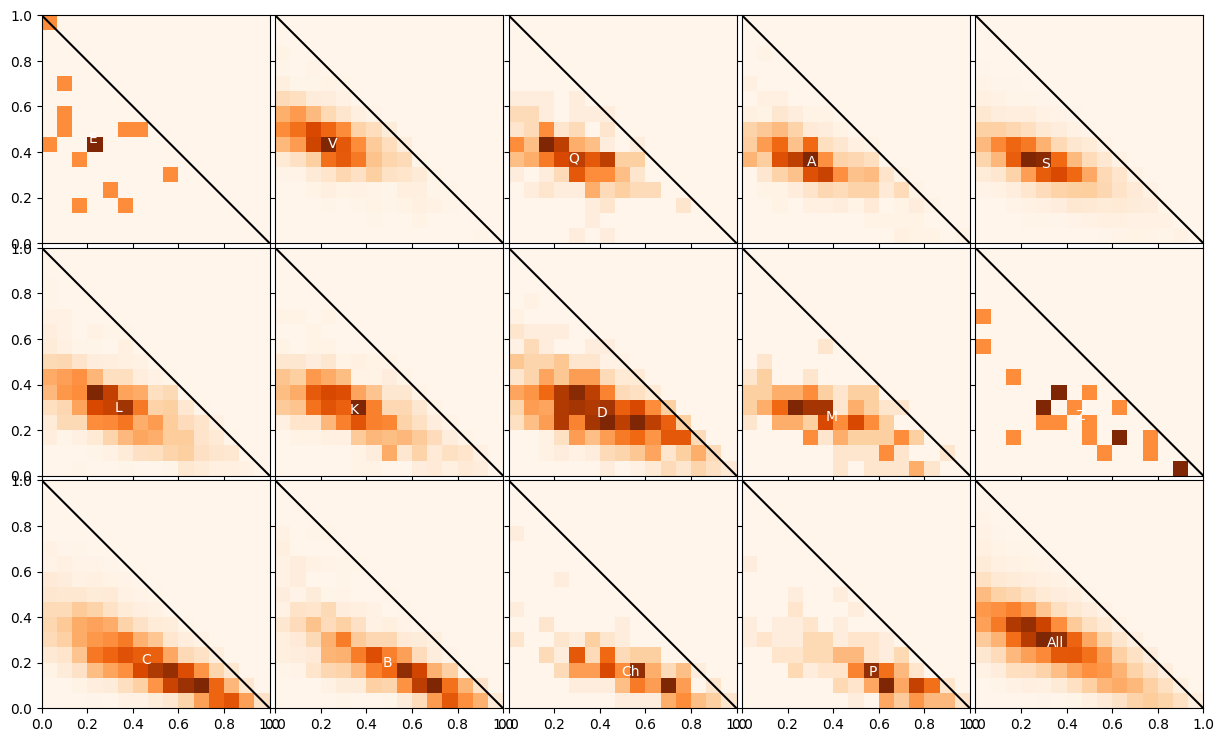

In [45]:
fig, ax = plt.subplots(
    3,
    5,
    figsize=(15, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
axs = ax.ravel()

xx = np.linspace(0, 1, num=40)

for a in axs:
    a.plot(xx, 1 - xx, linestyle="solid", color="black")
    a.set_aspect("equal")
    a.set_xlim(0, 1)
    a.set_ylim(0, 1)

r = [[0, 1], [0, 1]]
b = 15
for i, c in enumerate(
    ["E", "V", "Q", "A", "S", "L", "K", "D", "M", "Z", "C", "B", "Ch", "P"]
):
    cond = maskFINK & (data["taxonomy.complex"] == c)

    G1_m = data.loc[cond, "SHG1G2_G1_r"].mean()
    G1_s = data.loc[cond, "SHG1G2_G1_r"].std()
    G2_m = data.loc[cond, "SHG1G2_G2_r"].mean()
    G2_s = data.loc[cond, "SHG1G2_G2_r"].std()

    print(f"{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}")

    axs[i].hist2d(
        data.loc[cond, "SHG1G2_G1_r"],
        data.loc[cond, "SHG1G2_G2_r"],
        range=r,
        bins=b,
        cmap="Oranges",
    )
    axs[i].text(G1_m, G2_m, c, ha="center", va="center", color="white")


i = i + 1
G1_m = data.loc[maskFINK, "SHG1G2_G1_g"].mean()
G1_s = data.loc[maskFINK, "SHG1G2_G1_g"].std()
G2_m = data.loc[maskFINK, "SHG1G2_G2_g"].mean()
G2_s = data.loc[maskFINK, "SHG1G2_G2_g"].std()
axs[i].hist2d(
    data.loc[maskFINK, "SHG1G2_G1_g"],
    data.loc[maskFINK, "SHG1G2_G2_g"],
    range=r,
    bins=b,
    cmap="Oranges",
)
axs[i].text(G1_m, G2_m, "All", ha="center", va="center", color="white")

In [32]:
print("Difference of G1 G2 in g/r filters")

for i, c in enumerate(
    ["E", "V", "Q", "A", "S", "L", "K", "D", "M", "Z", "C", "B", "Ch", "P"]
):
    cond = maskFINK & (data["taxonomy.complex"] == c)

    G1_m_g = data.loc[cond, "SHG1G2_G1_g"].mean()
    G1_s_g = data.loc[cond, "SHG1G2_G1_g"].std()
    G2_m_g = data.loc[cond, "SHG1G2_G2_g"].mean()
    G2_s_g = data.loc[cond, "SHG1G2_G2_g"].std()

    G1_m_r = data.loc[cond, "SHG1G2_G1_r"].mean()
    G1_s_r = data.loc[cond, "SHG1G2_G1_r"].std()
    G2_m_r = data.loc[cond, "SHG1G2_G2_r"].mean()
    G2_s_r = data.loc[cond, "SHG1G2_G2_r"].std()

    print(f"{c:2s}   {G1_m_g-G1_m_r:5.2f}   {G2_m_g-G2_m_r:5.2f} ")

Difference of G1 G2 in g/r filters
E    -0.06   -0.02 
V     0.02   -0.05 
Q     0.01   -0.03 
A     0.02   -0.03 
S     0.01   -0.03 
L     0.00   -0.02 
K    -0.01   -0.01 
D    -0.01   -0.00 
M     0.04   -0.02 
Z     0.04    0.01 
C    -0.03    0.00 
B    -0.02   -0.00 
Ch   -0.02   -0.02 
P    -0.04   -0.00 


# Color

E    0.45 0.35
V    0.62 0.19
Q    0.59 0.23
A    0.65 0.20
S    0.61 0.21
L    0.62 0.21
K    0.57 0.21
D    0.58 0.21
M    0.56 0.23
Z    0.63 0.19
C    0.44 0.23
B    0.42 0.21
Ch   0.40 0.19
P    0.44 0.19


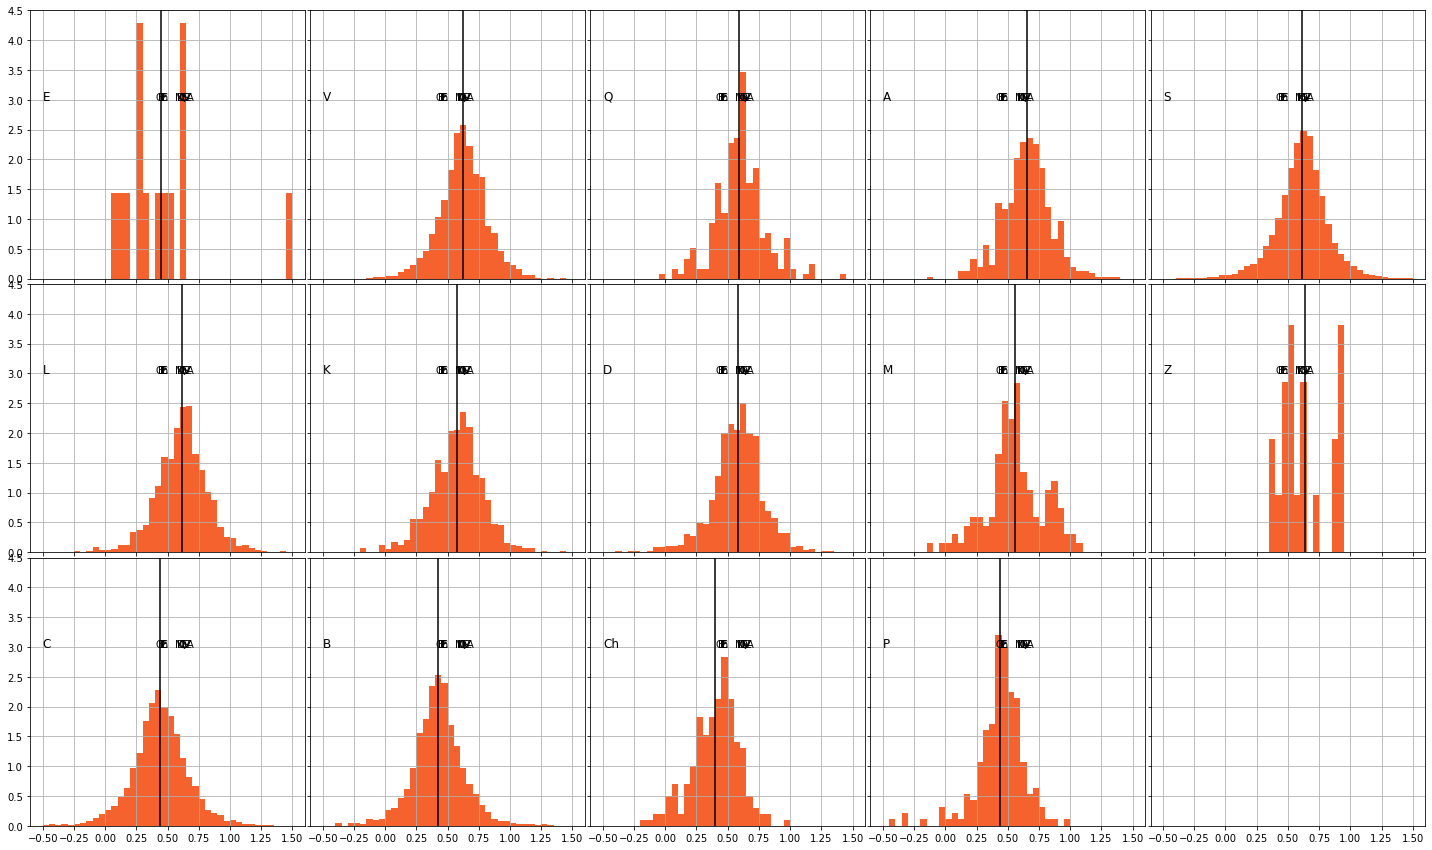

In [33]:
fig, ax = plt.subplots(
    3,
    5,
    figsize=(25, 15),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)
axs = ax.ravel()

xx = np.linspace(0, 1, num=40)

for a in axs:
    a.grid()
    # a.set_aspect('equal')
    # a.set_xlim(0,1)
    # a.set_ylim(0,1)

r = [-0.5, 1.5]
b = 40
complexes = ["E", "V", "Q", "A", "S", "L", "K", "D", "M", "Z", "C", "B", "Ch", "P"]
for i, c in enumerate(complexes):
    cond = maskFINK & (data["taxonomy.complex"] == c)

    x = data.loc[cond, "SHG1G2_H_g"] - data.loc[cond, "SHG1G2_H_r"]
    gr_m = x.mean()
    gr_s = x.std()
    print(f"{c:2s}   {gr_m:4.2f} {gr_s:4.2f}")

    axs[i].hist(x, range=r, bins=b, color=fink_colors[1], density=True)
    # axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )

    axs[i].axvline(gr_m, color="black")
    axs[i].text(-0.5, 3, c, fontsize="large")

    for k in range(len(complexes)):
        axs[k].text(gr_m, 3, c)

V 184
Q 20
A 37
S 1761
D 129
Z 1
C 737
B 179
V 393
Q 51
A 163
S 2083
D 210
Z 10
C 640
B 347


(-0.7, 0.5)

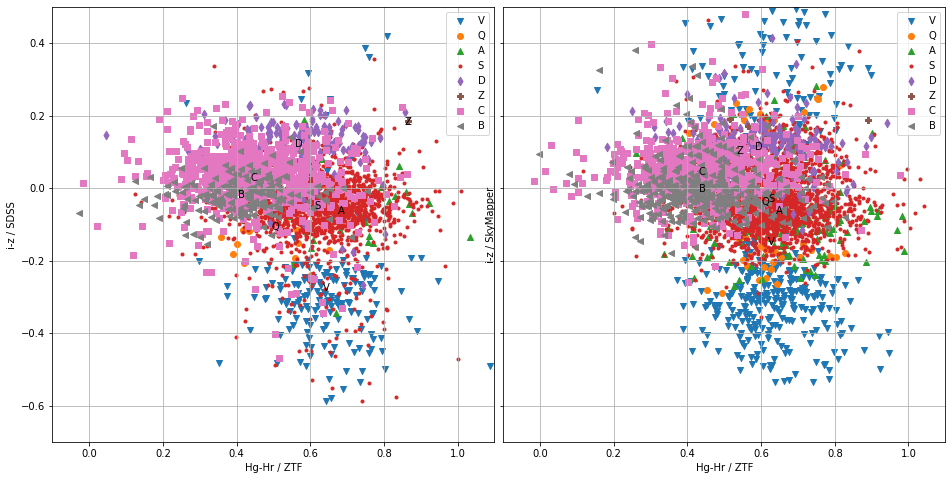

In [34]:
fig, ax = plt.subplots(1, 2,
    figsize=(16, 8),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)


for a in ax:
    a.grid()

complexes = ["E", "V", "Q", "A", "S", "L", "K", "D", "M", "Z", "C", "B", "Ch", "P"]
complexes = ["V", "Q", "A", "S", "D", "Z", "C", "B"]
markers = ['v','o','^','.','d','P','s','<']
for i, c in enumerate(complexes):
    cond = (
        maskFINK
        & (data["taxonomy.complex"] == c)
        & ((data["SHG1G2_dH_g"] + data["SHG1G2_dH_r"]) < 0.3)
        & (data["colors.i-z.facility"] == "SDSS")
        & (data["colors.i-z.color.value"].notna())
    )
    x = data.loc[cond, "SHG1G2_H_g"] - data.loc[cond, "SHG1G2_H_r"]
    y = data.loc[cond, "colors.i-z.color.value"]
    print( c, len(data[cond]))
    ax[0].scatter(x, y, label=c, marker=markers[i] )


    ax[0].text(x.mean(), y.mean(), c, ha='center', va='center', color='black' )
    # axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )


ax[0].legend()
ax[0].set_xlabel("Hg-Hr / ZTF")
ax[0].set_ylabel("i-z / SDSS")
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(-0.7, 0.5)


for i, c in enumerate(complexes):
    cond = (
        maskFINK
        & (data["taxonomy.complex"] == c)
        & ((data["SHG1G2_dH_g"] + data["SHG1G2_dH_r"]) < 0.3)
        & (data["colors.i-z.facility"] == "SMSS")
        & (data["colors.i-z.color.value"].notna())
    )
    x = data.loc[cond, "SHG1G2_H_g"] - data.loc[cond, "SHG1G2_H_r"]
    y = data.loc[cond, "colors.i-z.color.value"]
    print( c, len(data[cond]))
    ax[1].scatter(x, y, label=c, marker=markers[i] )


    ax[1].text(x.mean(), y.mean(), c, ha='center', va='center', color='black' )
    # axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )


ax[1].legend()
ax[1].set_xlabel("Hg-Hr / ZTF")
ax[1].set_ylabel("i-z / SkyMapper")
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(-0.7, 0.5)


In [35]:
def color_conv_ztf_panstarrs(filter, g_minus_r):
    """
    Return mag_ztf - mag_PS in g or r
    Medford 2020
    DOI 10.3847/2515-5172/ab7f3c
    """
    if filter == "g":
        return 0.055 * (g_minus_r) - 0.012
    else:
        return -0.087 * (g_minus_r) - 0.0035

In [36]:
def color_conv_panstarrs_sdss(filter, g_minus_i):
    """
    Return mag_PS - mag_SDSS in g or r
    Medford 2020
    DOI 10.3847/2515-5172/ab7f3c
    """
    if filter == "g":
        a0, a1, a2, a3 = -0.01808, -0.13595, 0.01941, -0.00183
    elif filter == "r":
        a0, a1, a2, a3 = -0.01836, -0.03577, 0.02612, -0.00558
    else:
        print("aie")

    return a0 + a1 * g_minus_i + a2 * g_minus_i**2 + a3 * g_minus_i**3

In [37]:
def color_conv_skymapper_sdss(color, value):
    """
    Return mag_skymapper - mag_sdss in g or r
    Medford 2020
    DOI 10.3847/2515-5172/ab7f3c
    """
    if color == "g-r":
        return 1.46534 * value + 0.027855
        
    if color == "g-i":
        return 1.171337 * value + 0.06685

    else:
        print("sm sdss aie")

4106


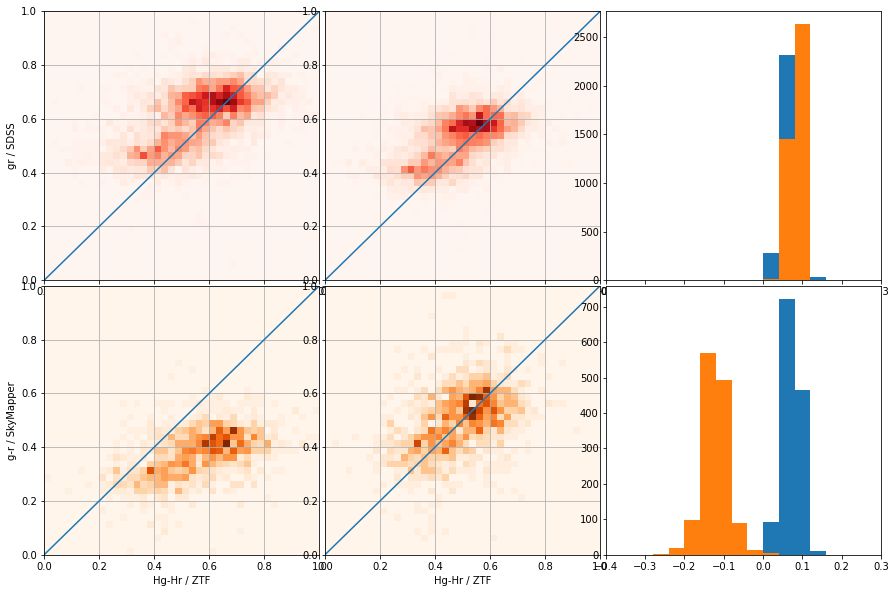

In [38]:
fig, ax = plt.subplots(
    2,
    3,
    figsize=(15, 10),
    # sharex=True,
    # sharey=True,
    gridspec_kw={"wspace": 0.02, "hspace": 0.02},
)



r = [[0, 1], [0, 1]]
b = 40

cond = (
    maskFINK
    & ((data["SHG1G2_dH_g"] + data["SHG1G2_dH_r"]) < 0.3)
    & (data["colors.g-r.facility"] == "SDSS")
    & (data["colors.g-r.color.value"].notna())
    & (data["colors.g-i.facility"] == "SDSS")
    & (data["colors.g-i.color.value"].notna())
)
x = data.loc[cond, "SHG1G2_H_g"] - data.loc[cond, "SHG1G2_H_r"]
y = data.loc[cond, "colors.g-r.color.value"]
y_gi = data.loc[cond, "colors.g-i.color.value"]
print(len(data[cond]))
# ax[0].scatter(x, y )


dmag_g = color_conv_ztf_panstarrs("g", x)
dmag_r = color_conv_ztf_panstarrs("r", x)
x2 = x - (dmag_g - dmag_r)

dmag_g = color_conv_panstarrs_sdss("g", y_gi)
dmag_r = color_conv_panstarrs_sdss("r", y_gi)
y2 = y + (dmag_g - dmag_r)

ax[0,0].hist2d(x, y, range=r, bins=b, cmap="Reds")
ax[0,1].hist2d(x2, y2, range=r, bins=b, cmap="Reds")

ax[0,2].hist(x-x2, range=[-1,1], bins=50, label='ZTF')
ax[0,2].hist(y-y2, range=[-1,1], bins=50, label='SDSS')


# VS SkyMapper
cond = (
    maskFINK
    & ((data["SHG1G2_dH_g"] + data["SHG1G2_dH_r"]) < 0.3)
    & (data["colors.g-r.facility"] == "SMSS")
    & (data["colors.g-r.color.value"].notna())
    & (data["colors.g-i.facility"] == "SDSS")
    & (data["colors.g-i.color.value"].notna())
)
x = data.loc[cond, "SHG1G2_H_g"] - data.loc[cond, "SHG1G2_H_r"]
y = data.loc[cond, "colors.g-r.color.value"]

dmag_g = color_conv_ztf_panstarrs("g", x)
dmag_r = color_conv_ztf_panstarrs("r", x)
x2 = x - (dmag_g - dmag_r)

y_sdss = color_conv_skymapper_sdss( 'g-r', y)
dmag_g = color_conv_panstarrs_sdss("g", data.loc[cond, "colors.g-i.color.value"])
dmag_r = color_conv_panstarrs_sdss("r", data.loc[cond, "colors.g-i.color.value"])
y2 = y_sdss + (dmag_g - dmag_r)


# print(len(data[cond]))
# # ax[1].scatter(x, y )
ax[1,0].hist2d(x, y, range=r, bins=b, cmap="Oranges")
ax[1,1].hist2d(x2, y2, range=r, bins=b, cmap="Oranges")

ax[1,2].hist(x-x2, range=[-1,1], bins=50, label='ZTF')
ax[1,2].hist(y-y2, range=[-1,1], bins=50, label='SDSS')

ax[1,1].set_xlabel("Hg-Hr / ZTF")
ax[1,0].set_ylabel("g-r / SkyMapper")

ax[1,0].set_xlabel("Hg-Hr / ZTF")
ax[0,0].set_ylabel("gr / SDSS")

xx = np.linspace(0, 1, num=10)
for a in ax[:,:2].ravel():
    a.set_xlim(r[0][0], r[0][1])
    a.set_ylim(r[1][0], r[1][1])
    a.plot(xx, xx)
    a.grid()

for a in ax[:,2]:
    a.set_xlim(-0.4,0.3)


(array([  3.,  15.,  41., 220., 519., 366., 101.,  18.,   6.,   4.]),
 array([-0.26424175, -0.23410988, -0.20397801, -0.17384614, -0.14371427,
        -0.11358239, -0.08345052, -0.05331865, -0.02318678,  0.00694509,
         0.03707697]),
 <BarContainer object of 10 artists>)

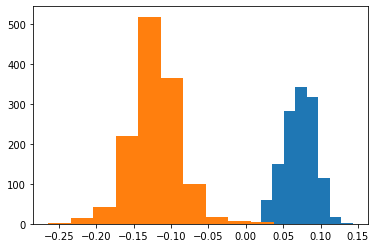

In [39]:
plt.hist(x-x2)
plt.hist(y-y2)

In [40]:
data.loc[maskFINK, "colors.g-r.facility"].value_counts()

colors.g-r.facility
SMSS       25652
SDSS       15831
ZTF          125
PdM/T1M        1
Name: count, dtype: int64

In [41]:
data["family.family_name"].value_counts().head(20)

family.family_name
Vesta         5451
Eos           3341
Hertha        2508
Koronis       2098
Hungaria      1803
Maria         1764
Themis        1599
Phocaea       1581
Eunomia       1285
Astraea       1171
Eulalia       1146
Baptistina    1021
Hygiea        1018
Iduna         1010
Minerva        940
Mnemosyne      661
Adeona         658
Euphrosyne     615
Flora          546
Massalia       506
Name: count, dtype: int64

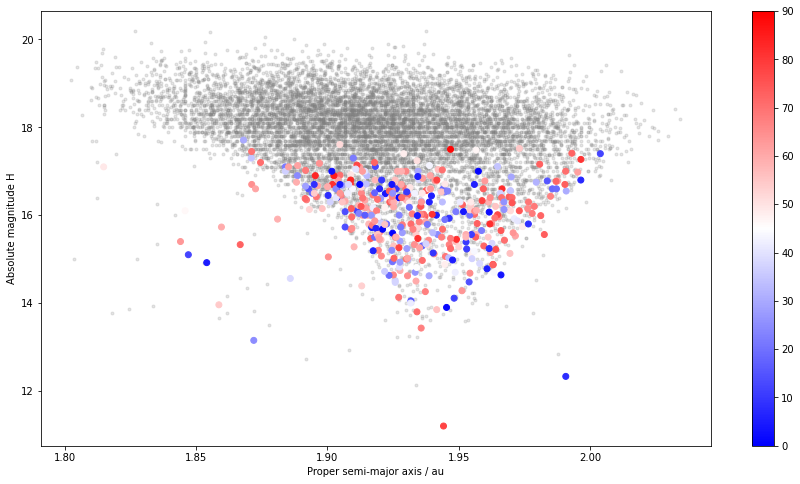

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))

f = "Hungaria"

cond = bft["family.family_name"] == f
ax.scatter(
    bft.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    bft.loc[cond, "absolute_magnitude.value"],
    color="grey",
    alpha=0.2,
    marker=".",
)


cond = maskFINK & (data["family.family_name"] == f)
im = ax.scatter(
    data.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    data.loc[cond, "absolute_magnitude.value"],
    c=np.abs(data.loc[cond, "obliquity"] - 90),
    vmin=0,
    vmax=90,
    alpha=1.0,
    marker="o",
    cmap="bwr",
)

ax.set_xlabel("Proper semi-major axis / au")
ax.set_ylabel("Absolute magnitude H")
fig.colorbar(im)

In [43]:
def yarkosvky_drift(
    H,
    period,
    albedo,
    density,
    inertia,
    mean_motion,
    dist_sun,
    obliquity,
    G=0.15,
    beaming=1.0,
    emissivity=0.9,
):
    """
    Compute the Yarkovsky drift in 10-4 au/Myr
    """
    solar_constant = 1360.8  # W m-2
    sigma_sb = 5.670374419e-8
    au = 1.495978707e11
    c_speed = 299792458.0

    # Mass (kg) & diameter (m)
    diameter = 1000.0 * (1329 / np.sqrt(albedo)) * 10.0 ** (-0.2 * H)
    mass = density * (4 * np.pi / 3) * (diameter / 2) ** 3

    # Subsolar temperature
    phase_integral = 0.29 + 0.684 * G
    bond_albedo = albedo * phase_integral
    T_ss = (
        (1 - bond_albedo)
        * solar_constant
        / (beaming * emissivity * sigma_sb * dist_sun**2)
    ) ** 0.25

    # Rotation frequency
    rot_freq = 2 * np.pi / (period * 3600)

    # Diurnal contribution
    theta_D = inertia * np.sqrt(rot_freq) / (emissivity * sigma_sb * T_ss**3)
    W_D = -0.5 * theta_D / (1 + theta_D + 0.5 * theta_D**2)

    # Annual contribution
    theta_A = inertia * np.sqrt(mean_motion) / (emissivity * sigma_sb * T_ss**3)
    W_A = -0.5 * theta_A / (1 + theta_A + 0.5 * theta_A**2)

    # Yarkovsky drift [m/s]
    drift = (
        ((1 - bond_albedo) / (9 * mean_motion))
        * np.pi
        * ((diameter) ** 2 / (mass * c_speed))
        * (solar_constant / dist_sun**2)
        * (
            W_A * np.sin(np.radians(obliquity)) ** 2
            - 2 * W_D * np.cos(np.radians(obliquity))
        )
    )

    # Yarkovsky drfit [10-4 au/Myr]
    return drift * (31557600.0 / (au * 1e-10))

In [44]:
H = 15
sun_dist = np.linspace(1.93, 1.33, num=10)
aaa = [sun_dist[0]]
cur = aaa[0]
for s in sun_dist:
    da = (
        yarkosvky_drift(
            H,
            period=8.0,
            albedo=0.4,
            density=2000,
            inertia=100,
            mean_motion=4.1e-8,
            dist_sun=s,
            obliquity=170,
        )
        * 1e-2
    )

    aaa.append(cur + da)
    cur = cur + da

apos = np.array(aaa[1:])

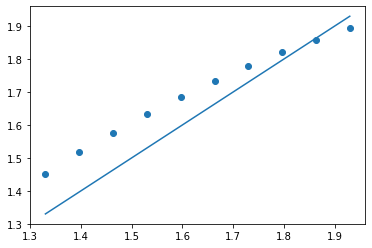

In [45]:
fig, ax = plt.subplots()

ax.scatter(sun_dist, apos)

ax.plot(sun_dist, sun_dist)

In [46]:
np.degrees(np.arcsin(0.04))

2.292442775955887

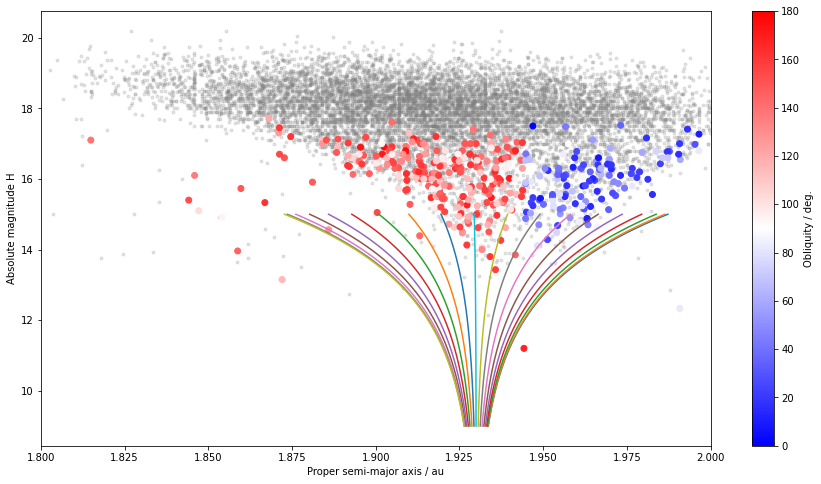

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))

f = "Hungaria"

c_fam_bft = bft["family.family_name"] == f
ax.scatter(
    bft.loc[c_fam_bft, "proper_elements.proper_semi_major_axis.value"],
    bft.loc[c_fam_bft, "absolute_magnitude.value"],
    color="grey",
    alpha=0.2,
    marker=".",
)

H_largest = bft.loc[c_fam_bft, "absolute_magnitude.value"].min()
cond = (bft["family.family_name"] == f) & (bft["absolute_magnitude.value"] == H_largest)
a_largest = bft.loc[cond, "proper_elements.proper_semi_major_axis.value"].values[0]

ac = 1.93
H = np.linspace(9, 15, num=100)
for obliquity in np.linspace(0, 180, num=19):
    da = (
        yarkosvky_drift(
            H,
            period=8.0,
            albedo=0.4,
            density=2000,
            inertia=10,
            mean_motion=7.1e-8,
            dist_sun=1.9,
            obliquity=obliquity,
        )
        * 1e-1
    )
    ax.plot(ac + da, H)

cond = (
    maskFINK
    & (data["family.family_name"] == f)
    & (data["proper_elements.proper_semi_major_axis.value"] <= a_largest)
)
left = data[cond].reset_index(drop=True)

cond = left["obliquity"] >= 90.0
im = ax.scatter(
    left.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    left.loc[cond, "absolute_magnitude.value"],
    c=left.loc[cond, "obliquity"],
    vmin=0,
    vmax=180,
    alpha=1.0,
    marker="o",
    cmap="bwr",
)
im = ax.scatter(
    left.loc[~cond, "proper_elements.proper_semi_major_axis.value"],
    left.loc[~cond, "absolute_magnitude.value"],
    c=left.loc[~cond, "obliquity_alt"],
    vmin=0,
    vmax=180,
    alpha=1.0,
    marker="o",
    cmap="bwr",
)

cond = (
    maskFINK
    & (data["family.family_name"] == f)
    & (data["proper_elements.proper_semi_major_axis.value"] > a_largest)
)
right = data[cond].reset_index(drop=True)
cond = right["obliquity"] <= 90.0
im = ax.scatter(
    right.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    right.loc[cond, "absolute_magnitude.value"],
    c=right.loc[cond, "obliquity"],
    vmin=0,
    vmax=180,
    alpha=1.0,
    marker="o",
    cmap="bwr",
)
im = ax.scatter(
    right.loc[~cond, "proper_elements.proper_semi_major_axis.value"],
    right.loc[~cond, "absolute_magnitude.value"],
    c=right.loc[~cond, "obliquity_alt"],
    vmin=0,
    vmax=180,
    alpha=1.0,
    marker="o",
    cmap="bwr",
)


ax.set_xlabel("Proper semi-major axis / au")
ax.set_ylabel("Absolute magnitude H")
ax.set_xlim(1.8, 2)
fig.colorbar(im, label="Obliquity / deg.")